# Uber Taxidaten in NYC
## Zeitraum April bis September 2014
- Rohdaten enthalten Datum mit Uhrzeit und den Länge/Breite, wohin ein Uber bestellt wurde
- jede Zeile repräsentiert eine Fahrt

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

%env SPARK_LOCAL_HOSTNAME=localhost
import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import *

env: SPARK_LOCAL_HOSTNAME=localhost


In [2]:
# Daten einlesen mit typisiertem Schema
# Dateipfad *.csv bedeutet alle csv werden geladen
spark = SparkSession.builder.appName("TaxiData").getOrCreate()

schema = StructType([
    StructField("date", StringType()),
    StructField("lat", DoubleType()),
    StructField("lon", DoubleType()),
    StructField("base", StringType())
])

csv = spark.read.option("header", "true").csv("./data/uber/*.csv", schema = schema).cache()

In [3]:
csv.show()

+----------------+-------+--------+------+
|            date|    lat|     lon|  base|
+----------------+-------+--------+------+
|8/1/2014 0:03:00|40.7366|-73.9906|B02512|
|8/1/2014 0:09:00| 40.726|-73.9918|B02512|
|8/1/2014 0:12:00|40.7209|-74.0507|B02512|
|8/1/2014 0:12:00|40.7387|-73.9856|B02512|
|8/1/2014 0:12:00|40.7323|-74.0077|B02512|
|8/1/2014 0:13:00|40.7349|-74.0033|B02512|
|8/1/2014 0:15:00|40.7279|-73.9542|B02512|
|8/1/2014 0:17:00| 40.721|-73.9937|B02512|
|8/1/2014 0:19:00|40.7195| -74.006|B02512|
|8/1/2014 0:20:00|40.7448|-73.9799|B02512|
|8/1/2014 0:21:00|40.7399|-74.0057|B02512|
|8/1/2014 0:25:00|40.7651|-73.9683|B02512|
|8/1/2014 0:27:00|40.7354|-74.0081|B02512|
|8/1/2014 0:29:00|40.7339|-74.0028|B02512|
|8/1/2014 0:29:00|40.7364|-74.0301|B02512|
|8/1/2014 0:29:00|40.7364|-74.0301|B02512|
|8/1/2014 0:30:00|40.7252|-73.9516|B02512|
|8/1/2014 0:30:00|40.7433| -73.986|B02512|
|8/1/2014 0:34:00|40.7437|-73.9884|B02512|
|8/1/2014 0:36:00|40.7406|-74.0077|B02512|
+----------

In [4]:
csv.count()

4534327

In [5]:
# erste Spalte als Datum noch auf String
# Ziel: echtes Datumsformat verwenden mittels eigener Funktion
csv.printSchema()

root
 |-- date: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- base: string (nullable = true)



In [6]:
# Bsp. Datum aus csv in Datumsformat umwandeln
###

# importiere datetime KLasse
from datetime import datetime

dateItem = "8/1/2014 0:36:00"

# Ausgabe Datumsobjekt
print(datetime.strptime("8/1/2014 0:36:00", "%m/%d/%Y %H:%M:%S"))

2014-08-01 00:36:00


**`strptime(date_string, format)`**
- *`date_string`* ist der Sring, wie er in den Daten vorliegt
- *`format`* muss das vorliegende Format des *`date_strings`* wiedergeben

In [7]:
# Benutzerdefinierte Funktion (User defined function)
from pyspark.sql.functions import udf

# mit dieser Funktion lässt sich die Datumsspalte umwandeln
f = udf(lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M:%S"), TimestampType())

**`udf` kann nun in der `withColumn()`-Funktion als zweiter Parameter zum Umwandeln in Datumsformat genutzt werden**

In [8]:
csv.withColumn("date", f(csv.date)).printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- base: string (nullable = true)



PySpark SQL - Dokumentation: http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html

In [9]:
# Fertige Formatierung der Daten
###
data = csv.withColumn("date", f(csv.date))
data.show()

+-------------------+-------+--------+------+
|               date|    lat|     lon|  base|
+-------------------+-------+--------+------+
|2014-08-01 00:03:00|40.7366|-73.9906|B02512|
|2014-08-01 00:09:00| 40.726|-73.9918|B02512|
|2014-08-01 00:12:00|40.7209|-74.0507|B02512|
|2014-08-01 00:12:00|40.7387|-73.9856|B02512|
|2014-08-01 00:12:00|40.7323|-74.0077|B02512|
|2014-08-01 00:13:00|40.7349|-74.0033|B02512|
|2014-08-01 00:15:00|40.7279|-73.9542|B02512|
|2014-08-01 00:17:00| 40.721|-73.9937|B02512|
|2014-08-01 00:19:00|40.7195| -74.006|B02512|
|2014-08-01 00:20:00|40.7448|-73.9799|B02512|
|2014-08-01 00:21:00|40.7399|-74.0057|B02512|
|2014-08-01 00:25:00|40.7651|-73.9683|B02512|
|2014-08-01 00:27:00|40.7354|-74.0081|B02512|
|2014-08-01 00:29:00|40.7339|-74.0028|B02512|
|2014-08-01 00:29:00|40.7364|-74.0301|B02512|
|2014-08-01 00:29:00|40.7364|-74.0301|B02512|
|2014-08-01 00:30:00|40.7252|-73.9516|B02512|
|2014-08-01 00:30:00|40.7433| -73.986|B02512|
|2014-08-01 00:34:00|40.7437|-73.9

## Zu welcher Uhrzeit (Stunde) wurden die meisten Taxis bestellt?
### Ziel: Plot der Anzahl an Fahrten (y) über den Tagesstunden (x)
**1. alle Funktionen aus pyspark.sql laden**
    - `import pyspark.sql.functions as F`
**2. Datumsspalte nach Stunden gruppieren und zählen**
    - `.date_format()` Funktion wandelt das Datum in einen String um, der nur die Stunden enthält
    - `.groupBy()` nutzt neue Zeit um zu gruppieren, enthält aber noch kein Format, das angezeigt werden kann
    - nach `.groupBy()` wird `.count()` genutzt, um diese zu zählen
    - Daten sind nun zwei Spalten mit den Stunden und der Anzahl Fahrten
**3. Neue Stundenspalte wieder in Integer umwandeln, damit aufsteigend sortiert werden kann**
    - es entsteht eine dritte Spalte `hour` aus der Stundenspalte
**4. Sortieren nach der Integer Spalte `hour`**
    - `.orderBy("hour")`
**5. Daten als Pythonobjekt abfragen**
    - `.collect()`
**6. Daten aus 5. in matplotlib geeignete arrays füllen**

**7. matplotlib nutzen**

In [10]:
# alle Funktionen aus pyspark.sql Modul laden
###
import pyspark.sql.functions as F

In [11]:
# Daten nach Stunden gruppieren und zählen
###
data.groupBy(F.date_format(data.date, "H")).count().show()
data.groupBy(F.date_format(data.date, "H")).count().printSchema()

+--------------------+------+
|date_format(date, H)| count|
+--------------------+------+
|                   7|193094|
|                  15|275466|
|                  11|165703|
|                   3| 48287|
|                   8|190504|
|                  22|241858|
|                  16|313400|
|                   0|103836|
|                   5| 83939|
|                  18|324679|
|                  17|336190|
|                   6|143213|
|                  19|294513|
|                  23|169190|
|                   9|159967|
|                   1| 67227|
|                  20|284604|
|                  10|159148|
|                   4| 55230|
|                  12|170452|
+--------------------+------+
only showing top 20 rows

root
 |-- date_format(date, H): string (nullable = true)
 |-- count: long (nullable = false)



**`date_format(date, format)` Funktion aus pyspark.sql:**  
Converts a date/timestamp/string to a value of string in the format specified by the date format given by the second argument.

A pattern could be for instance dd.MM.yyyy and could return a string like ‘18.03.1993’. All pattern letters of the Java class java.text.SimpleDateFormat can be used.

https://docs.oracle.com/javase/7/docs/api/java/text/SimpleDateFormat.html

In [12]:
# Gruppierte Daten nach Stundenspalte sortiert neu abspeichern
dataPerHour = data\
    .groupBy(F.date_format(data.date, "H"))\
    .count()\
    .orderBy("date_format(date, H)")\
    .cache()

In [13]:
# Da Stundenspalte ein String ist, wird diese noch umgewandelt
# anschließend wird nach der neuen umgewandelten Spalte sortiert
dataPerHour\
    .withColumn("hour", dataPerHour["date_format(date, H)"].cast(IntegerType()))\
    .orderBy("hour")\
    .show()

+--------------------+------+----+
|date_format(date, H)| count|hour|
+--------------------+------+----+
|                   0|103836|   0|
|                   1| 67227|   1|
|                   2| 45865|   2|
|                   3| 48287|   3|
|                   4| 55230|   4|
|                   5| 83939|   5|
|                   6|143213|   6|
|                   7|193094|   7|
|                   8|190504|   8|
|                   9|159967|   9|
|                  10|159148|  10|
|                  11|165703|  11|
|                  12|170452|  12|
|                  13|195877|  13|
|                  14|230625|  14|
|                  15|275466|  15|
|                  16|313400|  16|
|                  17|336190|  17|
|                  18|324679|  18|
|                  19|294513|  19|
+--------------------+------+----+
only showing top 20 rows



In [14]:
# Daten als Pythonobjekt abfragen
###
dataPerHourFetched = dataPerHour\
    .withColumn("hour", dataPerHour["date_format(date, H)"].cast(IntegerType()))\
    .orderBy("hour")\
    .collect()

In [15]:
print(dataPerHourFetched)

[Row(date_format(date, H)='0', count=103836, hour=0), Row(date_format(date, H)='1', count=67227, hour=1), Row(date_format(date, H)='2', count=45865, hour=2), Row(date_format(date, H)='3', count=48287, hour=3), Row(date_format(date, H)='4', count=55230, hour=4), Row(date_format(date, H)='5', count=83939, hour=5), Row(date_format(date, H)='6', count=143213, hour=6), Row(date_format(date, H)='7', count=193094, hour=7), Row(date_format(date, H)='8', count=190504, hour=8), Row(date_format(date, H)='9', count=159967, hour=9), Row(date_format(date, H)='10', count=159148, hour=10), Row(date_format(date, H)='11', count=165703, hour=11), Row(date_format(date, H)='12', count=170452, hour=12), Row(date_format(date, H)='13', count=195877, hour=13), Row(date_format(date, H)='14', count=230625, hour=14), Row(date_format(date, H)='15', count=275466, hour=15), Row(date_format(date, H)='16', count=313400, hour=16), Row(date_format(date, H)='17', count=336190, hour=17), Row(date_format(date, H)='18', cou

In [16]:
x = []
y = []
for row in dataPerHourFetched:
    x.append(row["date_format(date, H)"])
    y.append(row["count"])


In [17]:
%matplotlib inline

import matplotlib.pyplot as plt

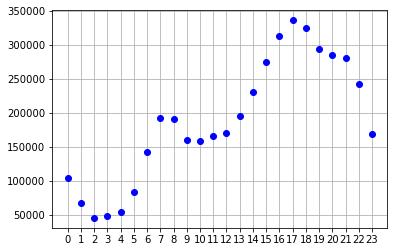

In [18]:
plt.plot(x, y, 'bo')
plt.grid()
plt.show()

Plot zeigt die kumulierte Anzahl an Fahrten je Tageszeit.